## GDScript - explorace výkonových charakteristik

#### GDScript - představení

GDScript je skriptovací jazyk integrovaný v opensource herním enginu Godot.  

Ačkoliv je možné ho v určitém smyslu považovat za jazyk relativně exotický, s nulovou uživatelskou základnou mimo Godot, pro uživatele Godotu bývá často z mnoha důvodů první volbou pro programování herní logiky. Jmenovitě proto, že funguje out-of-the-box na všech platformách, které Godot podporuje (narozdíl např. od C#, který je ošemetný na mobilních platformách), má poměrně použitelný editor a debugger integrovaný přímo do UI enginu, a mnoho specifických Godotích fíčur (např. signály, strom herní scény, singletony) je v něm podporováno velmi ergonomicky skrz dedikované jazykové konstrukty.

Nejde o jazyk designovaný pro dosažení co nejvyššího runtime výkonu, mnohem prioritnější je schopnost rychlé iterace a experimentování nad herní logikou ( -> pokud možno schopnost hotreload, nulové čekání na kompilaci, graduální typování), stručnost implementace jazyka, a přístupnost i pro nezkušené programátory. Nicméně, jedním výkonovým problémem, proti kterému se GDScript odhodlal vymezit, jsou, pro hry velmi palčivé, příležitostné propady framerate v důsledku běhu GC. Na rozdíl od většiny typických skriptovacích jazyků (Python, Lua apod.) zde nalezneme bohatý výběr užitečných "primitivních" datových typů schopných alokace na stacku a plnohodnotný GC byl zcela zrušen výměnou za (uživateli explicitně komunikovaný) reference counting. Všeobecně je uživatel designem jazyka nenápadně popostrkován, aby si vystačil co nejvíce pouze s primitivními typy a Nody herní scény (ty mají explicitní lifetime) a na reference counting musel spoléhat zřídka.   

Vcelku by se dalo říci, že jde o jazyk kdesi na pomezí mezi general-purpose a DSL.   

Z hlediska organizace zdrojového kódu, veškerá implementace GDSkriptího interpreteru, editoru, debuggeru apod. je jedním z mnoha podmodulů herního enginu, její zdrojový kód lze přečíst [zde](https://github.com/godotengine/godot/tree/master/modules/gdscript).    

Implementací jde o poměrně přímočarý bytecode interpreter, který se nepokouší o mnoho optimalizací.

Jazyk je spolu s celým enginem aktivně vyvíjen, celý tento text se vztahuje pouze na implementaci přítomnou v Godotu 4.4 (v době psaní nejnovější stabilní verze).  

#### Cíl experimentu

Vzhledem k tomu, že je GDScript poměrně niche jazyk používaný pouze ve velmi specifické sociální bublině, není toho o výkonu jeho implementace všeobecně mnoho známo.   

Tento experiment se nepokouší o srovnání výkonu GDScriptu s jinými v Godotu zprovoznitelnými skriptovacími jazyky.   
Vycházíme ze situace, kdy je již (z mnoha dobrých důvodů zmíněných výše) uživatel rozhodnut, že GDScript použije, a pokládá si otázku, jak svou logiku psát, aby se zbytečně neokrádal o výkon, popř. jaké (i třeba strukturu kódu zhoršující) poučky lze vytáhnout z rukávu, optimalizujeme-li na dřeň nějakou kritickou smyčku. V případě, že objevíme situaci, kde nejvýkonější postup je nevalně kompatibilní s dobrou štábní kulturou, zajímá nás jak velkou cenu platíme za čistý kód.     

S trochou štěstí v implementaci GDScriptu odhalíme nějaké výkonové deficity, které jsou snadno napravitelné bez nutnosti celou logiku interpreteru od základu překopat a mohou později být proměněny v pull-request.   

Postupovat budeme tak, že v GDScriptu napíšeme sérii mikrobenchmarků - pro běžné každodenní operace (jako např. control flow, čtení/zápis z proměnné/property, práce s datovými strukturami) představíme různé metody jak je provádět, které GDScript nabízí, a vzájemně porovnáme kolik času zabere jejich běh a kolik příp. alokují paměti. Obdobně vytvoříme mikrobenchmarky pro otestování, zda a za jakých okolností GDScript provádí některé obvyklé triviální optimalizace (constant-folding, eliminace kódu bez sideefektů apod.). 

Naměřená data následně porovnáme s intuitivními očekáváními a nesrovnalosti se pokusíme prozkoumat více do hloubky a vysvětlit, např. prohlížením vygenerovaného bytekódu, prokrokováním vnitřností interpreteru v debuggeru, popř. do překladače nebo interpreteru připíšeme drobné kousky kódu navíc, jako méně systematický ekvivalent instrumentace.   
Celkově náš úkol do jisté míry využijeme jako příležitost, abychom se seznámili s Godotí codebase.    


High-level shrnutí našich předběžných očekávání ohledně výkonu GDScriptu:
 - nejlepší výkon při použití jako "lepidlo" mezi nativními funkcemi
 -  ̶d̶y̶n̶a̶m̶i̶c̶k̶ý̶ ̶v̶s̶ ̶t̶y̶p̶o̶v̶a̶n̶ý̶ ̶k̶ó̶d̶ ̶b̶u̶d̶e̶ ̶s̶t̶e̶j̶n̶ě̶ ̶p̶o̶m̶a̶l̶ý̶,̶ ̶t̶y̶p̶y̶ ̶s̶l̶o̶u̶ž̶í̶ ̶p̶o̶u̶z̶e̶ ̶k̶ ̶p̶r̶o̶g̶r̶a̶m̶á̶t̶o̶r̶s̶k̶é̶m̶u̶ ̶p̶o̶h̶o̶d̶l̶í (odvoláno po zběžném nahlédnutí na [seznam opcodů](https://github.com/godotengine/godot/blob/3c7f9b937214068bc892be0d2bd9a8a7026edae1/modules/gdscript/gdscript_function.h#L331))
 - čím silněji typovaný kód, tím rychlejší (největší rozdíl pokud operuje nad primitivními typy)
 - pokud se držíme standardně uznávaných zásad čistého OOP kódu, neměl by se náš výkon diametrálně odchýlit od optima

#### Testovací sestava

Veškerá naměřená data byla pořízena na stolním PC:
 - CPU: Intel Core Ultra 7 265K, stock nastavení, chlazený vzduchem vždy pod 80°C
 - RAM: 2x16GB DDR5 6000MHz
 - OS: Windows 11 Pro 24H2
 - Godot: verze odpovídající obsahu branche `4.4` ke dni 27.8.2025, manuálně pořízený release build s vlastními úpravami (popsány dále)
 	- zdrojový kód forku lze nalézt v branchi [godot-fork](https://github.com/MarkusSecundus/NSWI131-Credit-GDScriptPerformanceEvaluation/tree/godot-fork)
	- benchmarkovací projekt lze nalézt v branchi [benchmarks](https://github.com/MarkusSecundus/NSWI131-Credit-GDScriptPerformanceEvaluation/tree/benchmarks)

#### Jak benchmarkovat GDScript

Forma mikrobenchmarků si v průběhu experimentu prošla několika iteracemi, zde popíšeme finální verzi ke které jsme došli:   

**Každý microbenchmark je definován třídou dědící z `IBenchmark`.**    
Implementuje funkce: 
 - `run_benchmark(repetitions_count: int, param_opt)->int`...
	- sama zodpovědná za pořízení timestampu na začátku a na konci, a za to, aby se payload provedl `repetitions_count`-krát
	- vrací čas v mikrosekundách, který zabralo provedení payloadu `repetitions_count`-krát (nejjemnější časovač, který Godot nabízí, je `Time.get_ticks_usec()` - [viz](https://gitlab.mff.cuni.cz/teaching/nswi131/2025/student-HRONIKJ/-/blob/master/task-01/01-timers/SOLUTION.ipynb?ref_type=heads) )
	- důvod: jak zjistíme, GDScript neprovádí inlinování funkcí ani v triviálních případech a volání funkce má overhead často několikanásobně větší než jedna instance našeho payloadu; rovněž se zde nekoná žádné inkrementální optimalizování funkcí na základě toho kolikrát byly volány  
	- v jiných jazycích typické akumulování dummy mezivýsledku, který pak vracíme z funkce, aby se zabránilo odoptimalizování payloadu pryč, zde není třeba - jak zjistíme, GDScript je schopen odoptimalizovávat kód pryč pouze ve velmi specifickém případě výrazů, které se plně zconstant-foldují
		- v některých microbenchmarcích budeme akumulaci mezivýsledků stále vykonávat, abychom zasadili použití payloadu do minimálního kontextu ve kterém dává smysl (např. sčítání dvou čísel nedává v praxi smysl pokud výsledek zahodíme a nikam ho neuložíme)
	- typický tvar funkce:
		```py
		func run_benchmark(repetitions: int, _param: Variant)->int:
			var param : some_type = _param  # optional 
			var start_time :int = Time.get_ticks_usec()
			for repetition in repetitions: # fastest way to iterate over <0;repetitions), no dynamic allocation
				# payload
			return Time.get_ticks_usec() - start_time
		```
 - `get_params()->Array` (volitelně)... 
	- vrací pole hodnot, benchmark se vykoná pro každou z hodnot
	- _jak později zjistíme, interakce s typovanou lokální proměnnou je zhruba stejně rychlá jako s konstantou_
 -  ve všech případech, kdy jsme k benchmarku potřebovali vykonávat přípravnou práci (alokace pomocných objektů nad kterými budeme operovat apod.), jsme si vystačili s konstruktorem, žádné metody `prepare()`, `cleanup()` apod. nebyly třeba

**Benchmarkovací framework...**
 - iteruje přes všechny benchmarky, pro každý benchmark:
	- vytvoří instanci jeho třídy (zavolá konstruktor který příp. vykoná přípravné operace)
	- pokud benchmark definuje `get_params()`, iteruje přes všechny parametry
	- nejprve zavolá `run_benchmark()` jednou na warmup
	- pak ho zavolá znovu už doopravdy, tentokrát se zapnutým trackováním dynamických alokací (viz dále)
	- **počet repeticí:** `10_000` pro warmup, `50_000` pro hlavní běh
	- vypíše naměřené výsledky do konzole (human readable forma) a volitelně do výstupního .csv souboru


**Provedená měření:**
 1. všechny benchmarky zopakovány 20-krát
 2. všechny benchmarky 20-krát, s warmupem `50_000`
 2. všechny benchmarky 20-krát, v převráceném pořadí
 3. všechny benchmarky 60-krát

V další části budeme primárně pracovat s daty ze všech těchto 4 běhu konkatenovanými dohromady. Uvidíme, že mezi daty z různých běhů nejsou patrné větší rozdíly, z toho plyne, že:
 - `10_000` opakování je na warmup dostatečné
 - pořadí, ve kterém jsou benchmarky vykonávány, na jejich běh nemá vliv
 - Godot netrpí na memory leaky/fragmentaci haldy či podobné vlivy, které by jeho běh v průběhu času zpomalovaly
 - stejně tak nevykonává žádné profilovací optimalizace, které by v dlouhodobém horizontu zvyšovaly výkon programu čím déle běží

In [211]:
# Define the format of measurements

import numpy as np
from matplotlib import pyplot as plt
from collections import defaultdict
from dataclasses import dataclass

ArithmeticBenchmarks = "ArithmeticBenchmarks"
IterationBenchmarks = "IterationBenchmarks"
FunctioncallBenchmarks = "FunctioncallBenchmarks"
DatastructBenchmarksLoad = "DatastructBenchmarksLoad"
DatastructBenchmarksStore = "DatastructBenchmarksStore"
DatastructBenchmarksCreation = "DatastructBenchmarksCreation"
ConversionBenchmarks = "ConversionBenchmarks"


@dataclass
class Measurement:
	usec : float
	allocs : float
	frees : float
	reallocs : float
	alloc_bytes : float
	free_bytes : float

	is_memory_leak: bool

def all_usecs(measurements: list[Measurement])->list[float]: return [x.usec for x in measurements]
def all_allocs(measurements: list[Measurement])->list[float]: return [x.allocs for x in measurements]
def all_frees(measurements: list[Measurement])->list[float]: return [x.frees for x in measurements]
def all_reallocs(measurements: list[Measurement])->list[float]: return [x.reallocs for x in measurements]
def all_alloc_bytes(measurements: list[Measurement])->list[float]: return [x.alloc_bytes for x in measurements]
def all_free_bytes(measurements: list[Measurement])->list[float]: return [x.free_bytes for x in measurements]
def all_is_memory_leak(measurements: list[Measurement])->list[bool]: return [x.is_memory_leak for x in measurements]


def load_measurements(path: str)->defaultdict:
	ret = defaultdict(dict)
	with open(path, "r") as f:
		for line_it in f:
			line :str = line_it
			fields = line.split(";")
			bench_section: str 	= fields[0]
			bench_name: str 	= fields[1]
			bench_param: str 	= fields[2]
			measured_usec_total = int(fields[3])
			repetitions_count	= int(fields[4])
			alloc_count_total	= int(fields[5])
			alloc_bytes_total	= int(fields[6])
			free_count_total	= int(fields[7])
			free_bytes_total	= int(fields[8])
			reallocs_count_total= int(fields[9])
			if not bench_name in ret[bench_section]:
				ret[bench_section][bench_name] = (defaultdict(list) if bench_param else list())
			bench_run = ret[bench_section][bench_name]
			if bench_param: bench_run = bench_run[bench_param]
			bench_run.append(Measurement(
				measured_usec_total / repetitions_count,
				alloc_count_total / repetitions_count,
				free_count_total / repetitions_count,
				reallocs_count_total / repetitions_count,
				alloc_bytes_total / repetitions_count,
				free_bytes_total / repetitions_count,
				(alloc_count_total != free_count_total)
			))

	return ret

def concat_measurements(a: defaultdict, b: defaultdict)->defaultdict:
	ret = defaultdict(dict)
	for section_name in a.keys():
		section_a: dict = a[section_name]
		for bench_name in section_a.keys():
			bench_a = section_a[bench_name]
			bench_b = b[section_name][bench_name]
			if isinstance(bench_a, list):
				ret[section_name][bench_name] =  bench_a + bench_b
			else:
				for bench_param in bench_a.keys():
					param_a = bench_a[bench_param]
					param_b = bench_b[bench_param]
					if not bench_name in ret[section_name]: ret[section_name][bench_name] = {}
					ret[section_name][bench_name][bench_param] = param_a + param_b
	return ret

def set_legend(legend):
    l = plt.legend(legend)
    for lh in l.legend_handles:
        lh.set_alpha(1)

def graph(d: dict, tests:list[str], selector, **kwargs):
	legend = []
	def pllt(values):
		plt.scatter(range(len(values)), values, **kwargs)

	for test in tests:
		if isinstance(test, str):
			if isinstance(d[test], list):
				pllt(selector(d[test]))
				legend.append(test)
			else:
				for param in d[test].keys():
					pllt(selector(d[test][param]))
					legend.append("%s[%s]"%(test, param))
		else:
			pllt(selector(d[test[0]][test[1]]))
			legend.append("%s[%s]"%(test[0], test[1]))

	
	plt.ylabel("μsec")
	plt.xlabel("run")
	set_legend(legend)
	plt.show()

def graph_usecs(d: dict, tests:list[str], **kwargs):
	graph(d, tests, all_usecs, **kwargs)


In [212]:
# Load all the measurements
measurements_basic = load_measurements("./measurements/out1.csv")

In [213]:
measurements_bigwarmup = load_measurements("./measurements/out2-big_warmup.csv")

In [214]:
measurements_backwards = load_measurements("./measurements/out3-backwards.csv")

In [215]:
measurements_big = load_measurements("./measurements/out4-big60.csv")

In [216]:
all_measurements = concat_measurements(concat_measurements(concat_measurements(measurements_basic, measurements_bigwarmup), measurements_backwards), measurements_big)

#### Aritmetika a přístupy k proměnným

Podívejme se nyní na nejzákladnější operace - aritmetiku a přístupy k proměnným.   

Pro všechny mikrobenchmarky z této sekce platí, že payload je 50-krát zopakovaná (copypaste) řádka s nějakou danou operací. _(Benchmarkujeme velmi rychlé elementární operace, chceme co nejvíce zredukovat overhead iterátoru. Z disassembleru zjistíme, že i pro takto nabobtnalé metody kód ani v nejdivočejším případě nepřekročí cca 6kB, měl by se tedy s přehledem vejít do 48kB datové L1 cache, kterou má testovací CPU)._     
Žádný z benchmarků nealokuje paměť.    

Podívejme se nyní blíže na operaci přístupu k proměnné. V následujících benchmarcích přičítáme k lokální proměnné hodnotu, která je specifikována jako literál/lokální/statická proměnná/property/funkce 

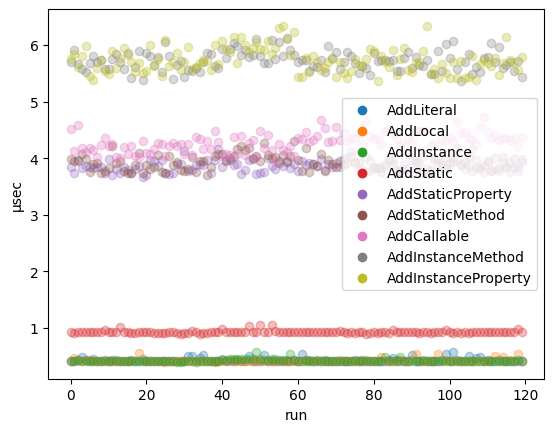

In [217]:
graph_usecs(all_measurements[ArithmeticBenchmarks], [
	"AddLiteral", "AddLocal", "AddInstance", "AddStatic", "AddStaticProperty", "AddStaticMethod", "AddCallable", "AddInstanceMethod", "AddInstanceProperty"
], alpha=0.3)


Vidíme, že přičítání literálu, lokální a instanční proměnné, jsou všechny zhruba stejně rychlé. Statická proměnná je několikrát pomalejší.   
Volání metody či property getteru je nepřekvapivě ještě o další řád pomalejší, avšak v tomto případě vítězí zhruba o polovinu statické metody nad instančními.

Tento rozdíl bych intuitivně vysvětlil tak, že instanční funkce musí pravděpodobně rozbíhat sofistikovanější mašinerii pro lookup napříč hierarchií dědičnosti, který nese overhead navíc i v optimistickém případě. S rozumnou pravděpodobností by zde mohl být prostor pro optimalizaci, avšak prozatím toto téma ponecháme.     

Podívejme se nyní ještě detailněji pouze na přístupy k proměnným:

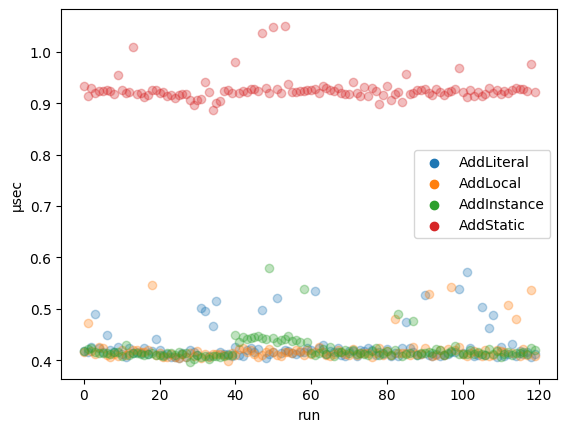

In [218]:
graph_usecs(all_measurements[ArithmeticBenchmarks], [
	"AddLiteral", "AddLocal", "AddInstance", "AddStatic"
], alpha=0.3)


Ano, statická proměnná se skutečně zdá být citelně pomalejší. Mějme na paměti, že měření v sobě také zahrnují overhead operace sčítání a uložení do lokální proměnné, statická proměnná je tedy o dost více než 2-krát pomalejší než lokální/instanční.     

Nyní když víme, že lokální proměnná, literál a instanční proměnná, jsou nejrychlejší, zaměřme se nyní na porovnání rychlosti různých aritmetických operací.

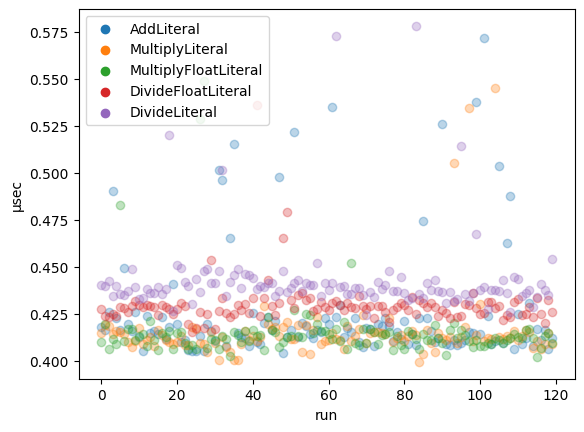

In [219]:
graph_usecs(all_measurements[ArithmeticBenchmarks], [
	"AddLiteral", "MultiplyLiteral", "MultiplyFloatLiteral",
	"DivideFloatLiteral", "DivideLiteral", 
	#"AddLocal_Vector2i", "AddLocal_Vector2f", "AddLocal_Vector3i", "AddLocal_Vector3f", "MultiplyLocal_Vector4f"
], alpha=0.3)


Mezi sčítáním a násobení intů i floatů je dostatečně malý rozdíl, aby se s přehledem schoval do overheadu interpreteru. Dělení je dostatečně drahá operace, aby již byla měřitelně (pořád v praxi zanedbatelně) pomalejší.    
Přibližme pouze na sčítání/násobení:   

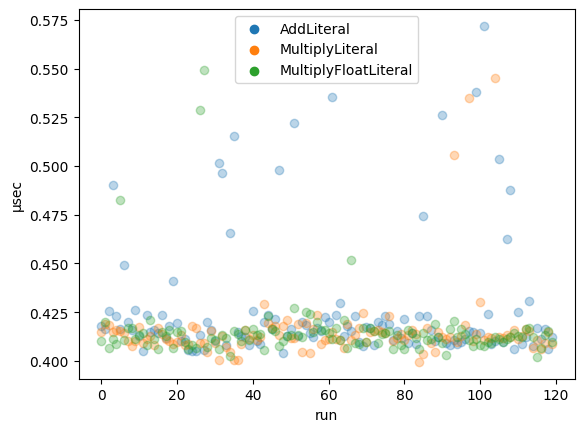

In [220]:
graph_usecs(all_measurements[ArithmeticBenchmarks], [
	"AddLiteral", "MultiplyLiteral", "MultiplyFloatLiteral",
], alpha=0.3)


V herní logice často pracujeme s 2 či 3-rozměrnými vektory. Jsou jejich operace natolik rychlé, aby dohromady s overheadem interpreteru byly srovnatelně rychlé jako skalární aritmetika?

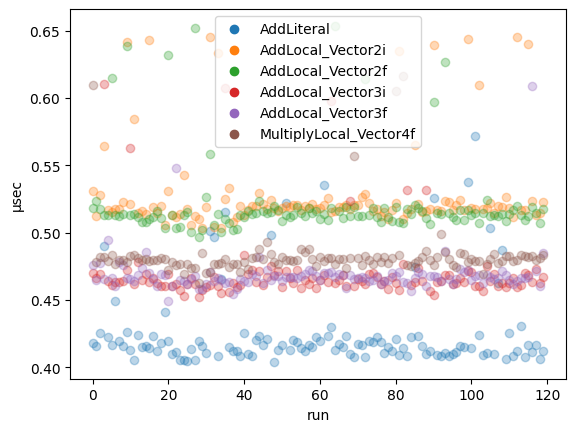

In [221]:
graph_usecs(all_measurements[ArithmeticBenchmarks], [
	"AddLiteral",
	"AddLocal_Vector2i", "AddLocal_Vector2f", "AddLocal_Vector3i", "AddLocal_Vector3f", "MultiplyLocal_Vector4f"
], alpha=0.3)


Vektorové operace jsou pomalejší než skalární jen velmi zanedbatelnou mírou. Je zajímavé, že 2D vektory jsou pomalejší než 3D/4D, možná se u větších vektorů používá SIMD instrukce zatímco 2D je ponechán s dvěmi skalárními (to by vysvětlilo téměř nulový rozdíl mezi 3D a 4D vektorem), v každém případě rozdíl není natolik značný, aby lákal k průzkumu.   
Je třeba nést na paměti, že vektory standardně nesou 32-bitové floaty (možné změnit flagem při kompilaci enginu), kdežto skalární float je vždy 64-bitový.    

Podívejme se nyní na složitější skalární funkce. 

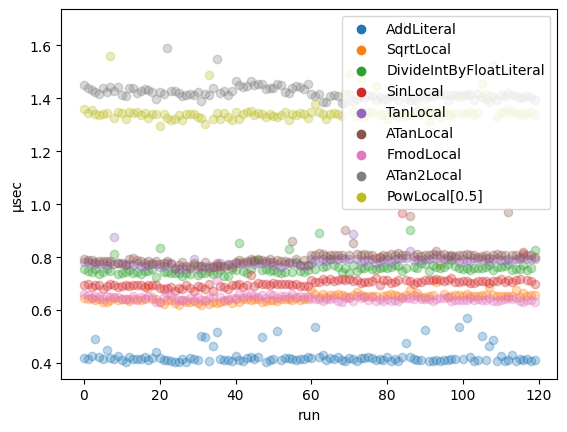

In [222]:
graph_usecs(all_measurements[ArithmeticBenchmarks], [
	"AddLiteral", "SqrtLocal", "DivideIntByFloatLiteral",
	"SinLocal", "TanLocal", "ATanLocal", "FmodLocal", "ATan2Local", ("PowLocal", "0.5")
], alpha=0.3)


Vidíme, že většina funkcí je nanejvýš dvakrát pomalejší než sčítání. Vydělení intu floatem a uložení do intu, je zhruba stejně pomalé jako spočítání atan z floatu a uložení do floatu.  
Sqrt je o tolik zanedbatelně pomalejší, že operace nad druhou mocninou délky místo reálné délky vektoru programátor v GDScriptu dělá spíše ze zvyku, než že by tím měl jakýkoliv reálný vliv na výkon. Pow a Atan2 jsou o trochu pomalejší, ale stále by z jejich použití programátor neměl mít výčitky.       
Samozřejmě tyto závěry, vyvozené z jednoho konkrétního stroje není záhodno brát příliš vážně. Jiná CPU mohou mít matematické instrukce o tolik pomalejší, že tu bude patrný značnější rozdíl.     

##### Constant folding

Nyní se zaměřme na optimalizace, které kompilátor nad kódem provádí - jmenovitě constant folding.   

První z benchmarků nese payload `ret += 42`, druhý `ret += 21 + 9 + 7 + 5 * 1` (kde `var ret: int = 1`)


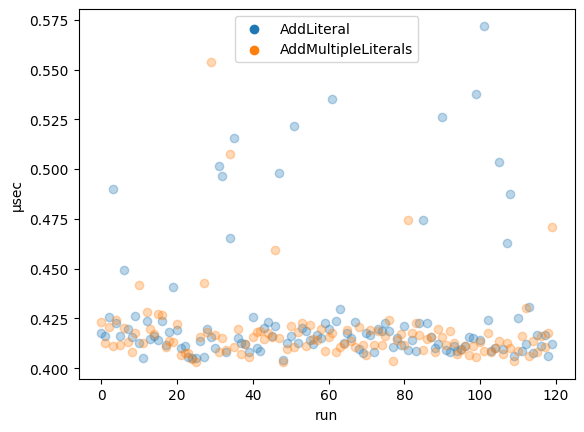

In [223]:
graph_usecs(all_measurements[ArithmeticBenchmarks], [
	"AddLiteral", "AddMultipleLiterals"
], alpha=0.3)

Zde máme payloady `ret *= 17.0` a `ret *= (1.0/0.0588)` (opět `var ret: float = 1.0`)

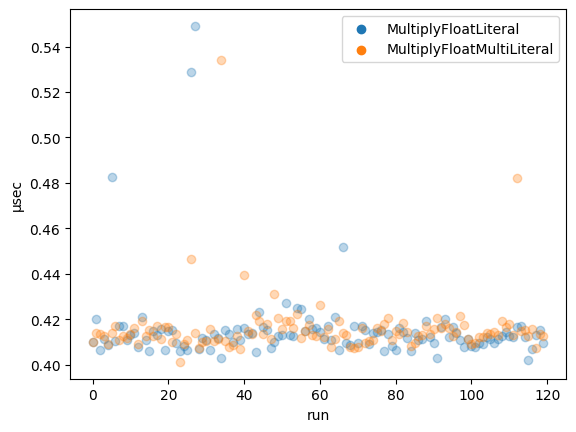

In [224]:
graph_usecs(all_measurements[ArithmeticBenchmarks], [
	"MultiplyFloatLiteral", "MultiplyFloatMultiLiteral"
], alpha=0.3)

Výsledky jsou pro obě varianty srovnatelné, ke constant foldingu tedy zajisté dochází, alespoň pro základní aritmetické operace.    

Postavme nyní proti sobě varianty, kde payload je pouze `pass` (prázdný příkaz), součet intových literálů, stringový literál a konkatenace více stringových literálů - ve všech případech dostaneme zhruba stejný čas běhu. Konstanty tedy s největší pravděpodobností byly zahozeny.   

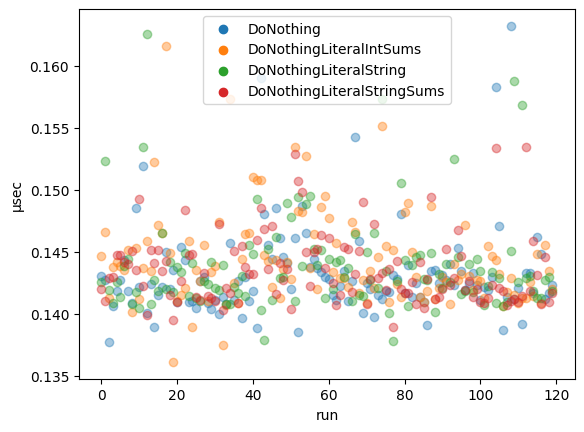

In [226]:
graph_usecs(all_measurements[ArithmeticBenchmarks], ["DoNothing", "DoNothingLiteralIntSums", "DoNothingLiteralString", "DoNothingLiteralStringSums"], alpha=0.4)